# Getting Started

The main purpose of this tutorial is to ease the implementation of our library `scikit-activeml` to the new users. The `scikit-activeml` is a library that executes the most important query strategies. It is built upon the well-known machine learning frame-work `scikit-learn`, which makes it user-friendly. For better understanding, we show an exemplary cycle here. Lets start by importing the relevant packages from both `scikit-learn` and `scikit-activeml`. 

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from skactiveml.pool import UncertaintySampling
from skactiveml.utils import is_unlabeled, MISSING_LABEL, plot_2d_dataset
from skactiveml.classifier import SklearnClassifier
import warnings
warnings.filterwarnings("ignore")

## Data-set Generation
We generate a data-set of 100 data points with two clusters from `make_classification` method of `scikit-learn`. We acquire its true labels as well, but in practice, it is not the case and we do not know them unless we ask the oracle. The class for each data point is already stored in `y_true`, which acts as an oracle. 

Text(0.5, 1.0, 'Data-set')

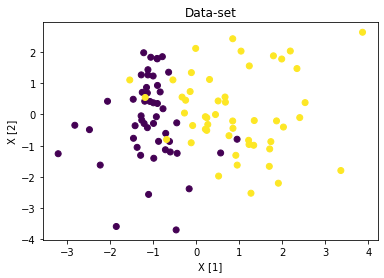

In [138]:
X, y_true = make_classification(n_features=2,n_redundant=0,random_state=0)
plt.scatter(X[:,0],X[:,1], c=y_true)
plt.xlabel('X [1]')
plt.ylabel('X [2]')
plt.title('Data-set')


## Classification
Our goal is to classify the data points into two classes. To do so, we introduce a vector `y` to store the labels that would be acquired from the oracle (`y_true`). As shown below, the vector `y` is unlabeled at the beginning.

In [139]:
y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
print(y)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


There are many easy-to-use classification algorithms in `scikit-learn`. For example, here we use the logistic regression classifier. Details of other classifiers can be accessed from here: https://scikit-activeml.readthedocs.io/en/latest/api/classifier.html. As `scikit-learn` classifiers are not able to cope with missing labels, we need to wrap these with the `SklearnClassifier`

In [140]:
clf = SklearnClassifier(LogisticRegression(),  classes=np.unique(y_true))

## Query Strategy
Query strategy is the central part of our library. As a query strategy, we use the uncertainty sampling with entropy method to specify the most uncertain data points. There are other strategies as well to be used, which can be accessed from here: https://scikit-activeml.readthedocs.io/en/latest/api/pool.html.   

In [141]:
qs = UncertaintySampling(clf, method='entropy', random_state=42)

## Active Leraning Cycle
As an example, we choose to loop around the active learning cycle *20* times (`n_cycles`), and the number of labels to be acquired is the multiplication of `batch_size` and `n_cycles`. 
Inside the loop, we first get the unlabeled indices of vector `y`. All the indices for *100* data points are unlabeled, because we are at the first iteration. Then, we use those unlabeled indices to create a list of labeling set, which contain unlabeled data set, and ask the query strategy to give us the indices of the most informative data points in `X_cand`. It will return indices equal to the number of`batch_size`, and data point corresponds to these indices are the most informative ones to be labeled. In our case, the output is just a single index, because the `batch_size` is *1*.
Finally, we ask the oracle for the true label of the selected data point and store it in vector `y` to train our classifier. We continue until we reach the *20* labeled data points. 
Below, we see the implementation of an active learning cycle. The first figure shows the decision boundary after acquiring the label of two data points. The second figure is after having 11 labeled data points from the oracle, which shows significant improvement compare to the first figure. The last figure shows the decision boundary after acquiring labels for *20* data points. Finally, we show the data points that were selected for labeling (vector `y`). 

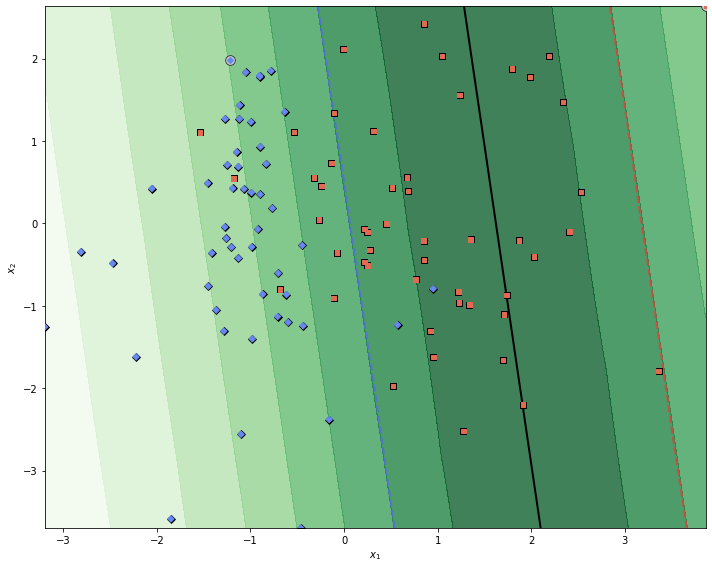

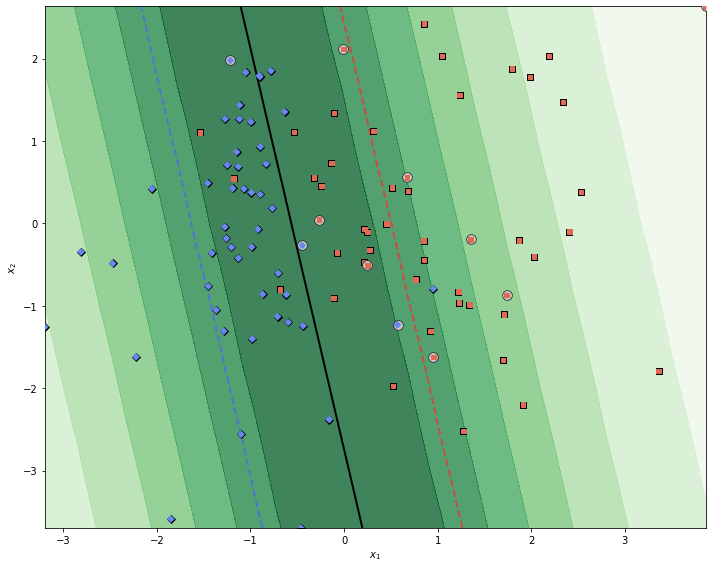

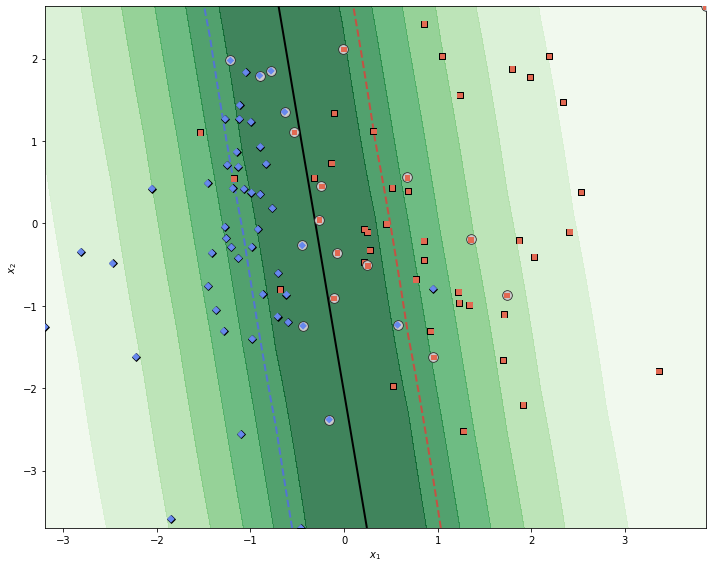

[nan nan nan nan nan  1. nan nan nan nan nan nan nan nan nan  1. nan nan
  0. nan  1. nan nan nan nan nan nan nan nan  1. nan nan nan nan nan nan
  0. nan nan nan nan nan nan  1. nan nan nan  0.  1. nan nan  1. nan nan
 nan nan nan nan nan  0. nan  0. nan nan  1.  0. nan nan nan nan nan nan
 nan nan nan  0. nan  1.  0. nan nan nan  1. nan nan nan nan nan  1. nan
 nan nan  1. nan nan nan nan nan nan nan]


In [142]:
n_cycles = 20
for c in range(n_cycles):
     unlbld_idx = np.where(is_unlabeled(y))[0]
     X_cand = X[unlbld_idx]
     query_idx = unlbld_idx[qs.query(X_cand=X_cand, X=X, y=y, batch_size=1)]
     y[query_idx] = y_true[query_idx]
     clf.fit(X, y)
     if c == 1:
         plot_2d_dataset(X, y, y_true, clf, qs)
     elif c == 10:
         plot_2d_dataset(X, y, y_true, clf, qs)
     elif c == 19:
        plot_2d_dataset(X, y, y_true, clf, qs)

print(y)